In [2]:
# EffiColorizer modules
from EffiColorizer.preprocessing import *
from EffiColorizer.discriminator import *
from EffiColorizer.losses import *
from EffiColorizer.generator import *
from EffiColorizer.train import *
from EffiColorizer.main_model import *
# other modules
import torch
from torch.utils.tensorboard import SummaryWriter

In [ ]:
IMG_SIZE = 320
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

# Part 1 - Data Preprocessing

In [ ]:
path = "your_dataset_directory"
train_paths, val_paths = train_validation_split(path, train_size=0.8, example_size=20_000, random_state=123)
print(len(train_paths), len(val_paths))

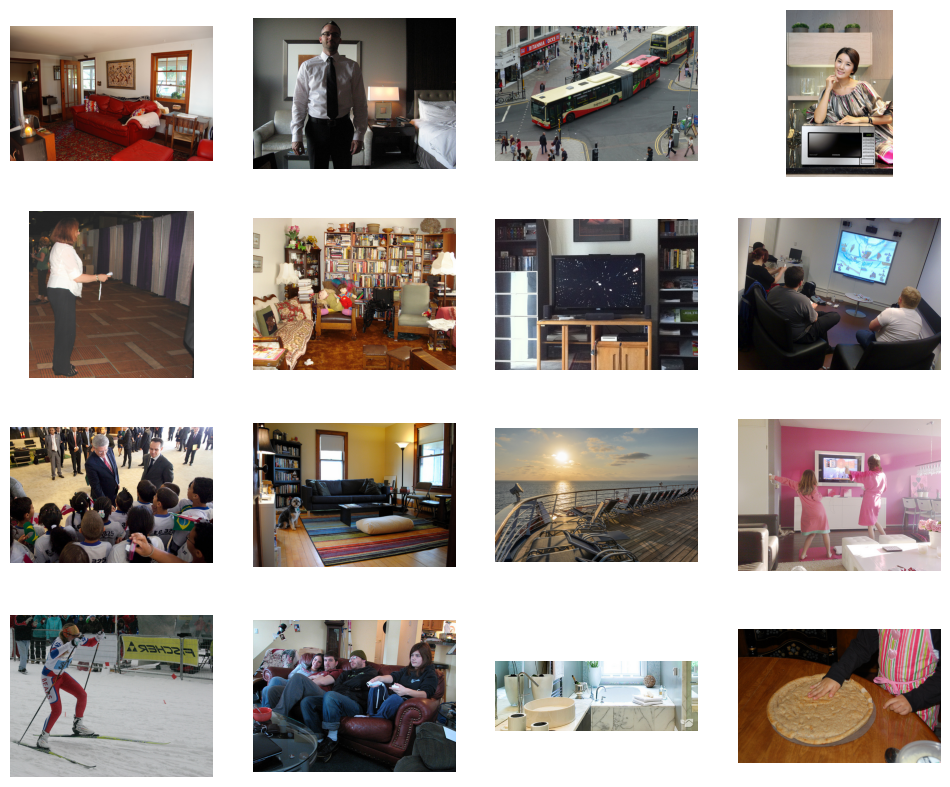

In [6]:
imgs = open_imgs(train_paths[:16])
plot_imgs(imgs, ncols=4, figsize=(12, 10))

In [ ]:
# For Windows
train_dl = make_dataloaders(batch_size=BATCH_SIZE, shuffle=True, n_workers=0, paths=train_paths, split='train', size=IMG_SIZE)
val_dl = make_dataloaders(batch_size=BATCH_SIZE, shuffle=True, n_workers=0, paths=val_paths, split='val', size=IMG_SIZE)

# For Linux
# train_dl = make_dataloaders(batch_size=BATCH_SIZE, shuffle=True, n_workers=4, paths=train_paths, split='train', size=IMG_SIZE)
# val_dl = make_dataloaders(batch_size=BATCH_SIZE, shuffle=True, n_workers=4, paths=val_paths, split='val', size=IMG_SIZE)

print(len(train_dl), len(val_dl))

In [ ]:
eval_batch = next(iter(val_dl))
print(eval_batch['L'].shape, eval_batch['ab'].shape)

# Part 2 - Discriminator

In [ ]:
disc = Discriminator(in_channels=3, out_channels=1, filter_sizes=[64, 128, 256, 512, 512])
disc.to(DEVICE)
disc

In [ ]:
disc_dummy_input = torch.randn(size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), device=DEVICE)
out = disc(disc_dummy_input)
out.shape

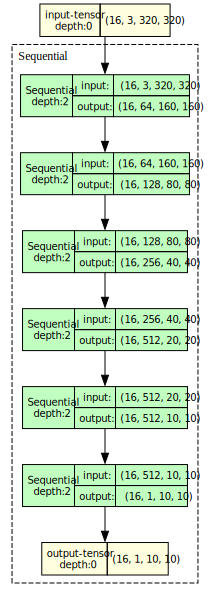

In [11]:
draw_model(model=disc, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=2,
           directory="./architectures", filename="disc")

In [12]:
from rf_calc import receptive_field
RF = receptive_field(disc, IMG_SIZE)

=======================================Reciptive Field Calculator========================================
|    | Kernel_size   |   Padding |   Stride | Input_Img_size   | Output_Img_size   | Receptive_field   |
|---:|:--------------|----------:|---------:|:-----------------|:------------------|:------------------|
|  0 | 4*4           |         1 |        2 | 320*320          | 160*160           | 4*4               |
|  1 | 4*4           |         1 |        2 | 160*160          | 80*80             | 10*10             |
|  2 | 4*4           |         1 |        2 | 80*80            | 40*40             | 22*22             |
|  3 | 4*4           |         1 |        2 | 40*40            | 20*20             | 46*46             |
|  4 | 4*4           |         1 |        2 | 20*20            | 10*10             | 94*94             |
|  5 | 5*5           |         2 |        1 | 10*10            | 10*10             | 222*222           |


In [12]:
# writer = SummaryWriter(log_dir='./tensor_board/disc')
# writer.add_graph(disc, input_to_model=disc_dummy_input)
# writer.close()

In [13]:
# write the following command in python terminal to open TensorBoard:     
#      tensorboard --logdir=./tensor_board
# or write the following in the jupyter notebook cells:     
#      !tensorboard --logdir=./tensor_board
# you can also use %%cmd in windows or %%bash in linux

# Part 3 - Generator

In [ ]:
gen = generator_V2(IMG_SIZE)
gen.to(DEVICE)
gen

In [ ]:
gen_dummy_input = torch.randn(size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE), device=DEVICE)
out = gen(gen_dummy_input)
out.shape

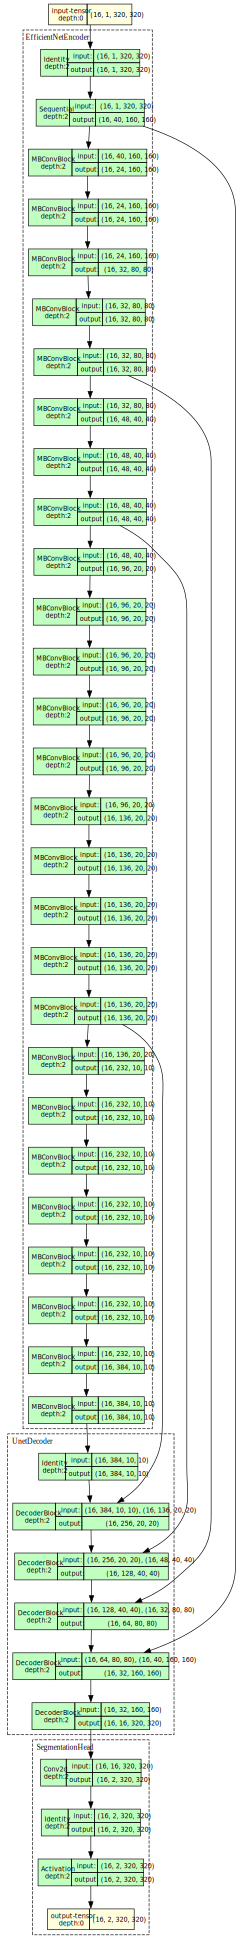

In [14]:
draw_model(model=gen, input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE), depth=2,
           directory="./architectures", filename="gen")

In [17]:
# writer = SummaryWriter(log_dir='./tensor_board/gen')
# writer.add_graph(gen, input_to_model=gen_dummy_input)
# writer.close()

In [18]:
# write the following command in python terminal to open TensorBoard:     
#      tensorboard --logdir=./tensor_board
# or write the following in the jupyter notebook cells:     
#      !tensorboard --logdir=./tensor_board
# you can also use %%cmd in windows or %%bash in linux

# Part 4 - GAN loss

In [ ]:
GAN_loss = BCE_GANLoss()
GAN_loss(predictions=torch.rand(16, 1), label='real')

# Part 5 - Wight Initialization

In [ ]:
show_parameters(disc)

In [ ]:
init_weights(model=disc, init='norm')
show_parameters(disc)

In [ ]:
show_parameters(gen)

# Part 5 - Main Model

In [19]:
main_model = MainModel(net_G=gen, net_D=disc, device=DEVICE)

# Part 6 - Pretraining the Generator

In [20]:
trainer = TrainGAN(model=main_model, data_loader=train_dl, eval_data=eval_batch, running_avg_window=50)

In [25]:
main_model.set_hyperparameters(lr_G=1e-4)
trainer.pretrain_generator(epochs=10)

In [26]:
# torch.save(gen.state_dict(), "pretrained_gen.pt")

# Part 7 - Training the Main Model

In [ ]:
main_model.set_hyperparameters(GAN_loss=GAN_loss, lr_G=1e-4, lr_D=1e-4, beta1=0.9, beta2=0.999, lambda_L1=100., 
                               train_G=True, train_D=True)
trainer.train_main_model(epochs=10)

In [56]:
torch.save(main_model.state_dict(), "main_model.pt")